      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758                 

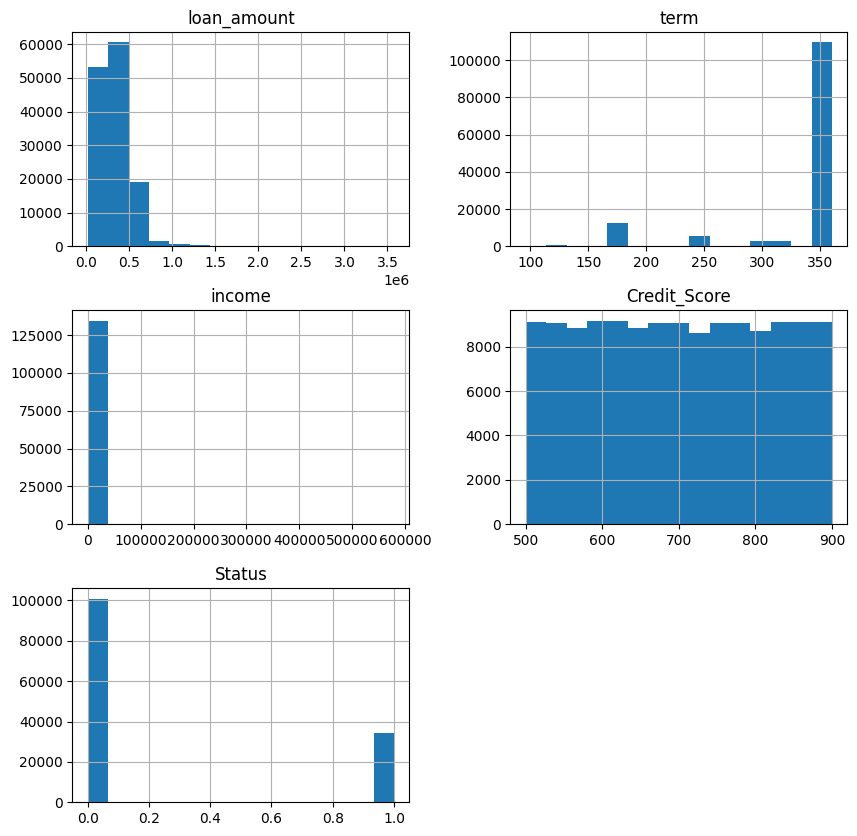

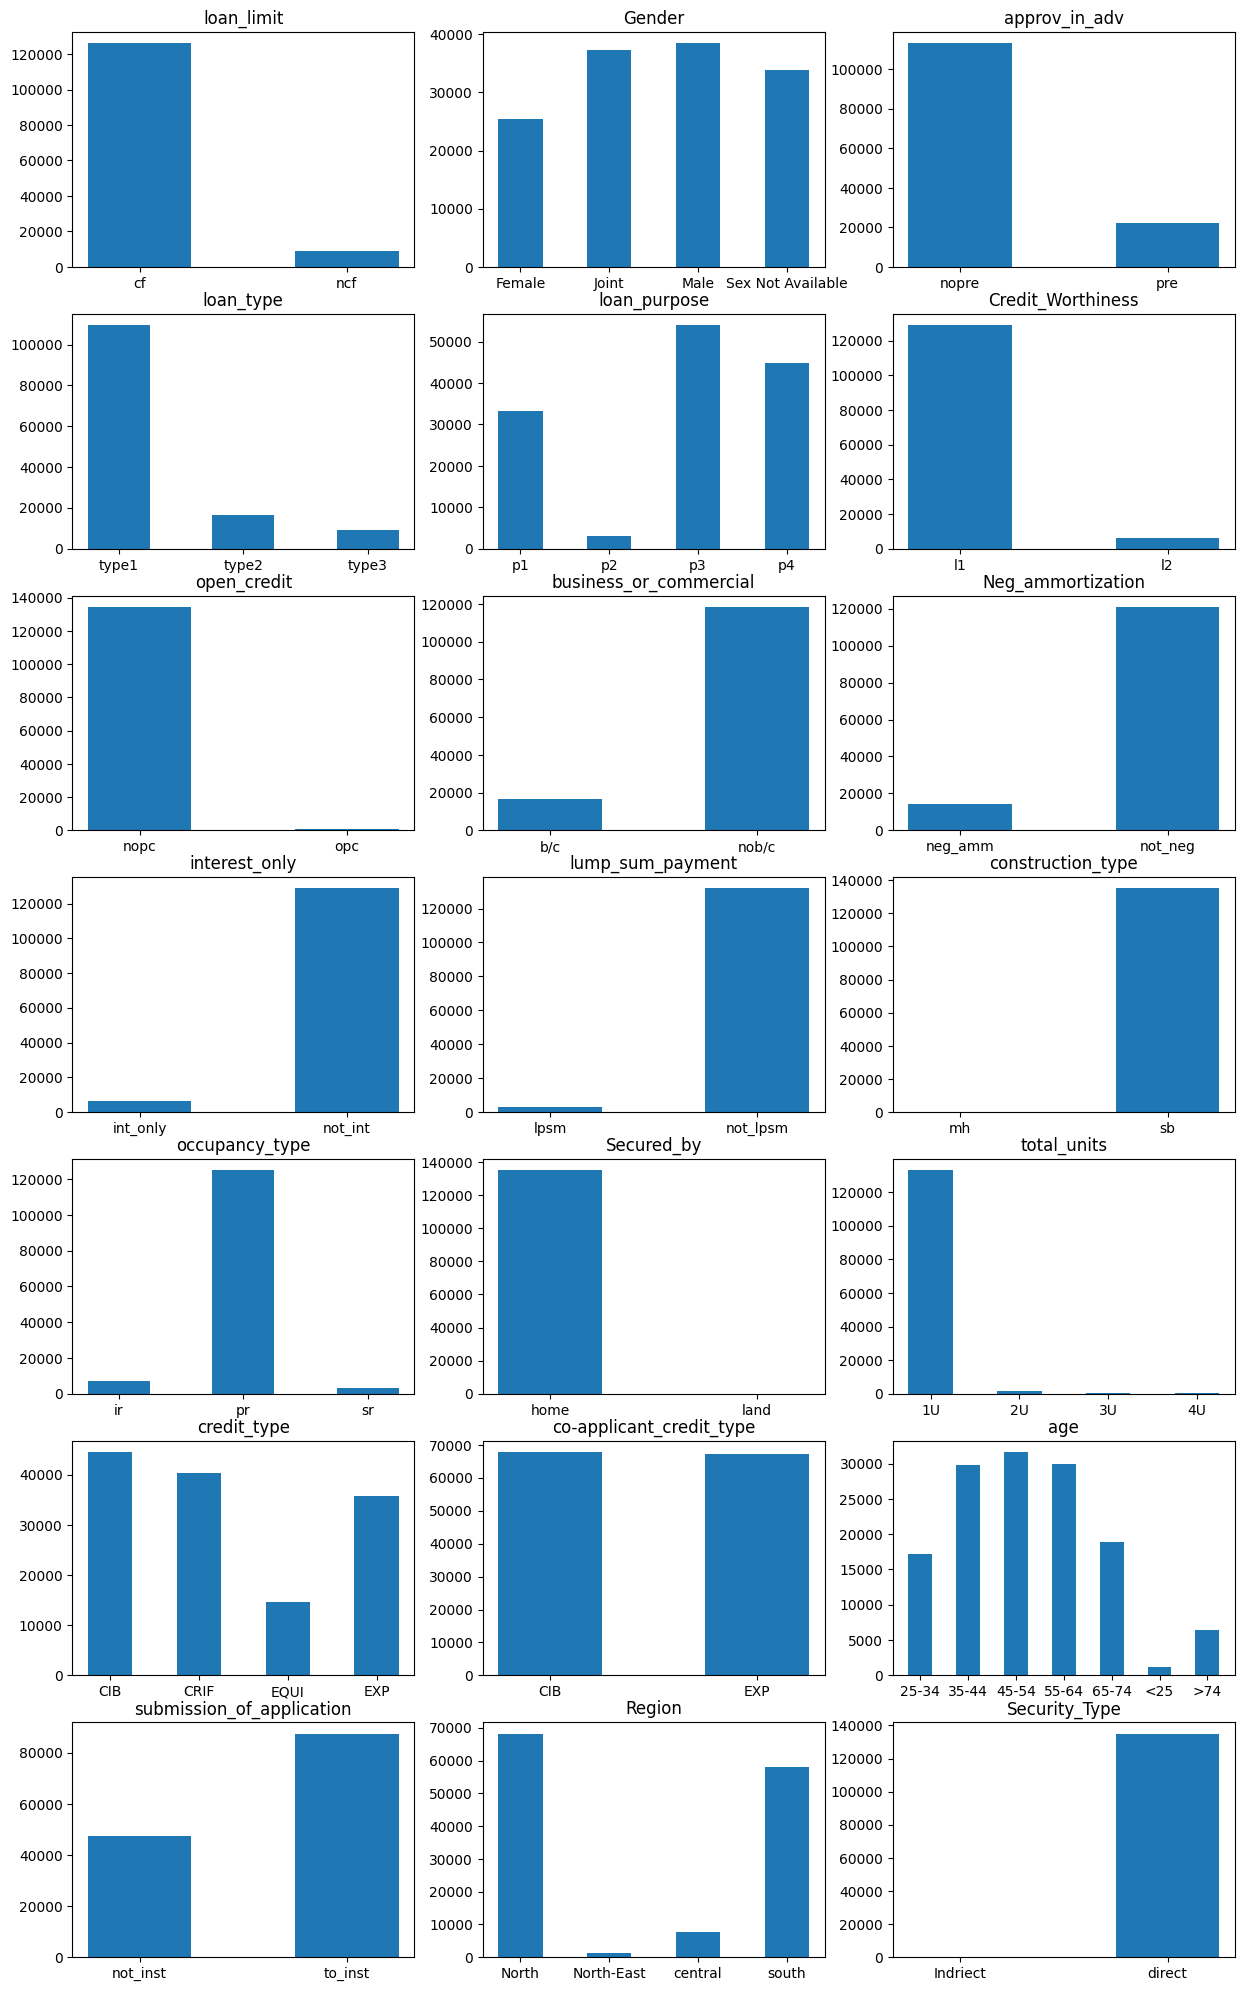

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../data/Loan_Default.csv") # Read Data
print(data.head())

# drop the columns with too much null values in Status == 1
data = data.drop(["rate_of_interest", "Interest_rate_spread", "Upfront_charges", "property_value", "LTV", "dtir1"], axis=1)

# drop the useless columns.
data = data.drop(["ID", "year"], axis=1)

# drop the lines with null values.
data = data.dropna(axis=0, how="any")

# check the distribution of numeric columns.
data.hist(bins=15, figsize=(10,10))
plt.show()

# check the distribution of non-numeric columns.
object_list = list(data.columns[data.dtypes == "object"])
fig = plt.figure(figsize=(15,25))
n = 1
for column in object_list:
    d = pd.DataFrame(data.loc[:, [column, "Status"]]).groupby(column).count()["Status"]
    ax = fig.add_subplot(7, 3, n)
    ax.bar(height=d, x=[i for i in range(len(d))], width = 0.5)
    ax.set_xticks([i for i in range(len(d))])
    ax.set_xticklabels(list(d.index))
    ax.set_title(column)
    n +=1
plt.show()
